In [113]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from datetime import datetime
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# !pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import os
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as skl

np.random.seed(0)

In [114]:
columnName = 'TotalSales'
dataColumnName = 'Date'
dataForDates = pd.read_csv('file.csv')
data = dataForDates.drop(columns=dataColumnName)
data.TotalSales=data.TotalSales.mask(data.TotalSales.lt(0),0)

In [115]:
data.columns

Index(['Unnamed: 0', 'InvoiceID', 'ProductID', 'TotalSales', 'Discount',
       'CustomerID', 'Quantity'],
      dtype='object')

In [116]:
data.head()

,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,1684,796.610169,143.389831,185,4
1,1,329,524,355.932203,64.067797,185,2
2,2,330,192,901.694915,162.305085,230,4
3,3,330,218,182.754237,32.895763,230,1
4,4,330,247,780.101695,140.418305,230,4


In [117]:
dataForDates[dataColumnName] = pd.to_datetime(dataForDates[dataColumnName])
dataForDates.set_index(dataColumnName, inplace= True)
# data =data.resample('D').mean()
dataForDates.head()

,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,,
2019-12-27,0,328,1684,796.610169,143.389831,185,4
2019-12-27,1,329,524,355.932203,64.067797,185,2
2019-12-27,2,330,192,901.694915,162.305085,230,4
2019-12-27,3,330,218,182.754237,32.895763,230,1
2019-12-27,4,330,247,780.101695,140.418305,230,4


Предобработка данных

In [118]:
# Importing
import sklearn
import pandas as pd
 
# IQR
# Calculate the upper and lower limits
Q1 = data[columnName].quantile(0.10)
Q3 = data[columnName].quantile(0.90)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(data[columnName]>=upper)[0]
lower_array = np.where(data[columnName]<=lower)[0]
 
# Removing the outliers
data[columnName].drop(index=upper_array, inplace=True)
data[columnName].drop(index=lower_array, inplace=True)
 
# Print the new shape of the DataFrame
print("New Shape: ", data.shape)

New Shape:  (29103, 7)


In [119]:
data.shape

(29103, 7)

In [120]:
data.drop_duplicates()
data.shape

(29103, 7)

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  29103 non-null  int64  
 1   InvoiceID   29103 non-null  int64  
 2   ProductID   29103 non-null  int64  
 3   TotalSales  29103 non-null  float64
 4   Discount    29103 non-null  float64
 5   CustomerID  29103 non-null  int64  
 6   Quantity    29103 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.6 MB


In [122]:
from scipy.interpolate import interp1d

In [123]:
data[columnName] = data[columnName].interpolate()# we will fill the null row

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29103 entries, 0 to 29102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  29103 non-null  int64  
 1   InvoiceID   29103 non-null  int64  
 2   ProductID   29103 non-null  int64  
 3   TotalSales  29103 non-null  float64
 4   Discount    29103 non-null  float64
 5   CustomerID  29103 non-null  int64  
 6   Quantity    29103 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.6 MB


In [125]:
train = data

In [126]:
target = columnName
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
dataset_name = 'Table'

In [127]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Set 3


In [128]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

# Список типа int индексов категориальных признаков
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# Список типа int, количество уникальных значений для категориального признака, новые модальности не могут быть предсказаны
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Список типа int размеров вложений для каждой категориальной функции (по умолчанию =1)
# Определение размеров: здесь просто случайный набор
cat_emb_dim = [5, 4, 3, 6, 2, 2, 9, 10]

In [129]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

train.head()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity,Set
0,0,328,1684,796.610169,143.389831,185,4,1
1,1,329,524,355.932203,64.067797,185,2,1
2,2,330,192,901.694915,162.305085,230,4,1
3,3,330,218,182.754237,32.895763,230,1,1
4,4,330,247,780.101695,140.418305,230,4,1


In [130]:
# np.массив особенностей обучения
X_train = train[features].values[train_indices]
# y_train - np.массив учебных целей
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

### Обучение модели методом Random Forest

In [131]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
 
# create regressor object
regressor = RandomForestRegressor(n_estimators=100, max_depth = 5, random_state = 18)
 
# fit the regressor with x and y data
regressor.fit(X_train, y_train)

RFpreds = regressor.predict(X_test)

<ipython-input-131-fcc94af7af48>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_train, y_train)


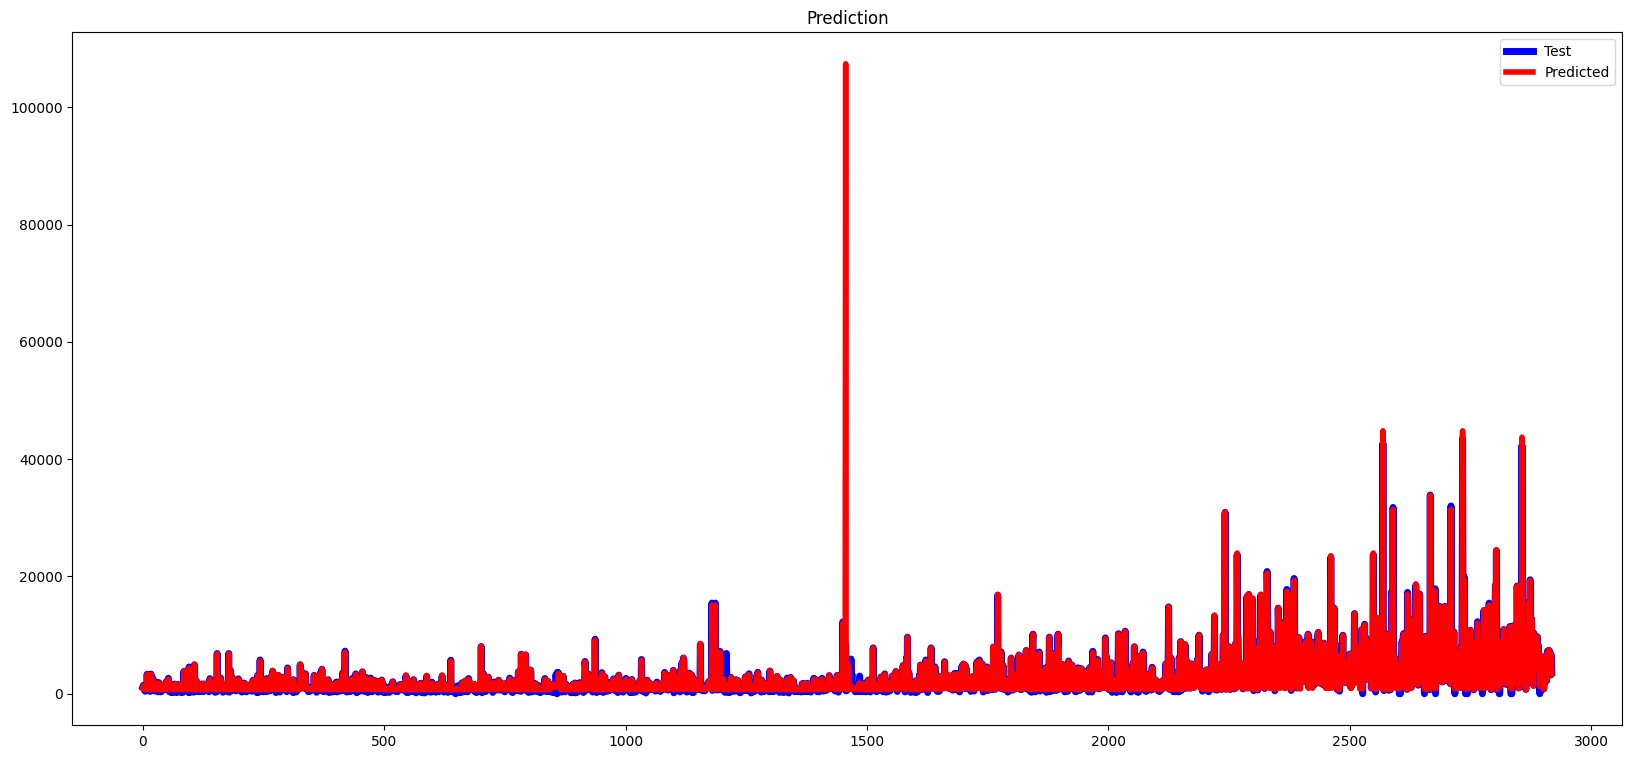

In [132]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(RFpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [133]:
score = r2_score(y_test, RFpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 68.0%


### Обучение модели нейросетевой архитектурой глубокого обучения TabNet

In [134]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [135]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [136]:
history = clf.fit(
    X_train=X_train, y_train=y_train,
    # Cписок оцениваемых наборов кортежей (X, y)
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    # Список строковых наборов имен eval
    eval_name=['train', 'valid'],
    # Список показателей оценки
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=50,
    # Количество последовательных периодов без улучшения перед выполнением ранней остановки
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
) 

epoch 0  | loss: 29074002.90146| train_rmsle: 10.11434| train_mae: 2476.92153| train_rmse: 5391.63007| train_mse: 29069674.81493| valid_rmsle: 9.923   | valid_mae: 2362.4006| valid_rmse: 4041.43908| valid_mse: 16333229.82316|  0:00:01s
epoch 1  | loss: 28948599.9819| train_rmsle: 9.51683 | train_mae: 2447.61872| train_rmse: 5353.01205| train_mse: 28654738.02343| valid_rmsle: 9.41304 | valid_mae: 2334.94658| valid_rmse: 3999.17521| valid_mse: 15993402.3311|  0:00:03s
epoch 2  | loss: 29700015.84256| train_rmsle: 10.73491| train_mae: 2460.51725| train_rmse: 5328.28474| train_mse: 28390618.29201| valid_rmsle: 10.63657| valid_mae: 2349.16954| valid_rmse: 3971.73453| valid_mse: 15774675.16692|  0:00:05s
epoch 3  | loss: 28881441.8765| train_rmsle: 8.85056 | train_mae: 2423.33177| train_rmse: 5271.69232| train_mse: 27790739.93878| valid_rmsle: 8.80659 | valid_mae: 2314.92734| valid_rmse: 3912.18438| valid_mse: 15305186.59066|  0:00:07s
epoch 4  | loss: 28442198.99026| train_rmsle: 6.20449 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [137]:
TNpreds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=TNpreds, y_true=y_true)

In [138]:
# Сохранение модели
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [139]:
# Определение новой модели с базовыми параметрами и весами состояния загрузки
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [140]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"ОКОНЧАТЕЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ {dataset_name} : {loaded_test_mse}")

ОКОНЧАТЕЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ Table : 135936.9317643512


In [141]:
assert(test_score == loaded_test_mse)

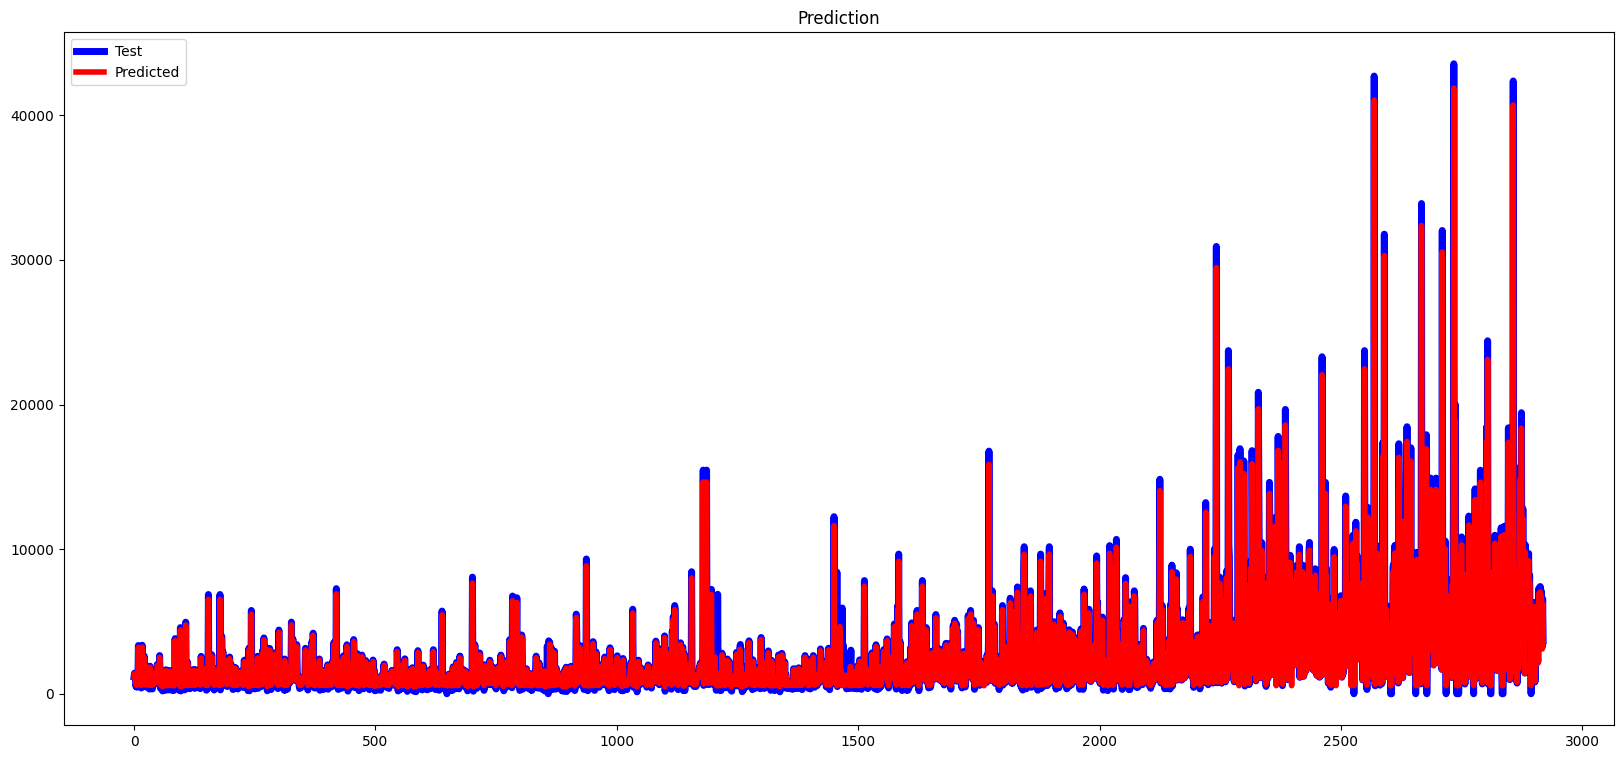

In [142]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(TNpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [143]:
score = r2_score(y_true, TNpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 99.0%


### Обучение модели при помощи библиотеки XGBoost

In [144]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter Optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                       {'max_depth': [3,5,7],
                       'n_estimators': [50,100,200]}, verbose=1)
reg_xgb.fit(X_train,y_train)
print(reg_xgb.best_score_)
print(reg_xgb.best_params_)

Parameter Optimization
Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.5346178523344388
{'max_depth': 3, 'n_estimators': 50}


In [145]:
XGBpreds = reg_xgb.predict(X_test)

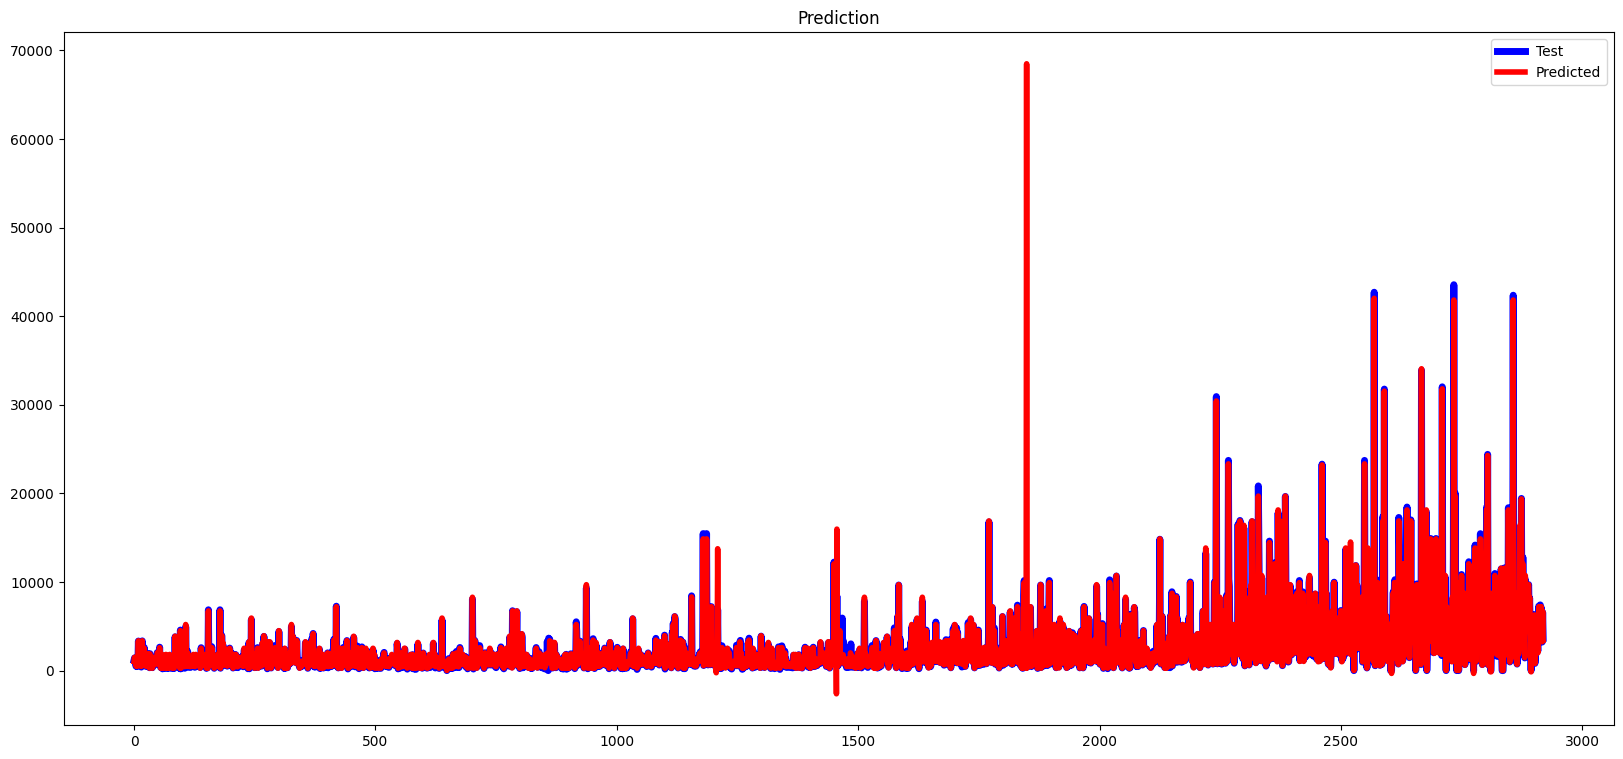

In [146]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(XGBpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [147]:
y_true = y_test
score = r2_score(y_true, XGBpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 86.0%


### Обучение модели при помощи фреймворка LightGBM

In [148]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 1,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 20,
    'verbose': 5
}
X_testlgbm = X_test
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_testlgbm, y_test, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=20)])

lGBMpreds = gbm.predict(X_test)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.003782
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.002948 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 23311, number of used features: 6
[LightGBM] [Info] Start training from score 2577.228589
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 9
Training until validation scores don't improve for 20 rounds
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 50 and depth = 18
[LightGBM] [Debug] Trained a tree with leav

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


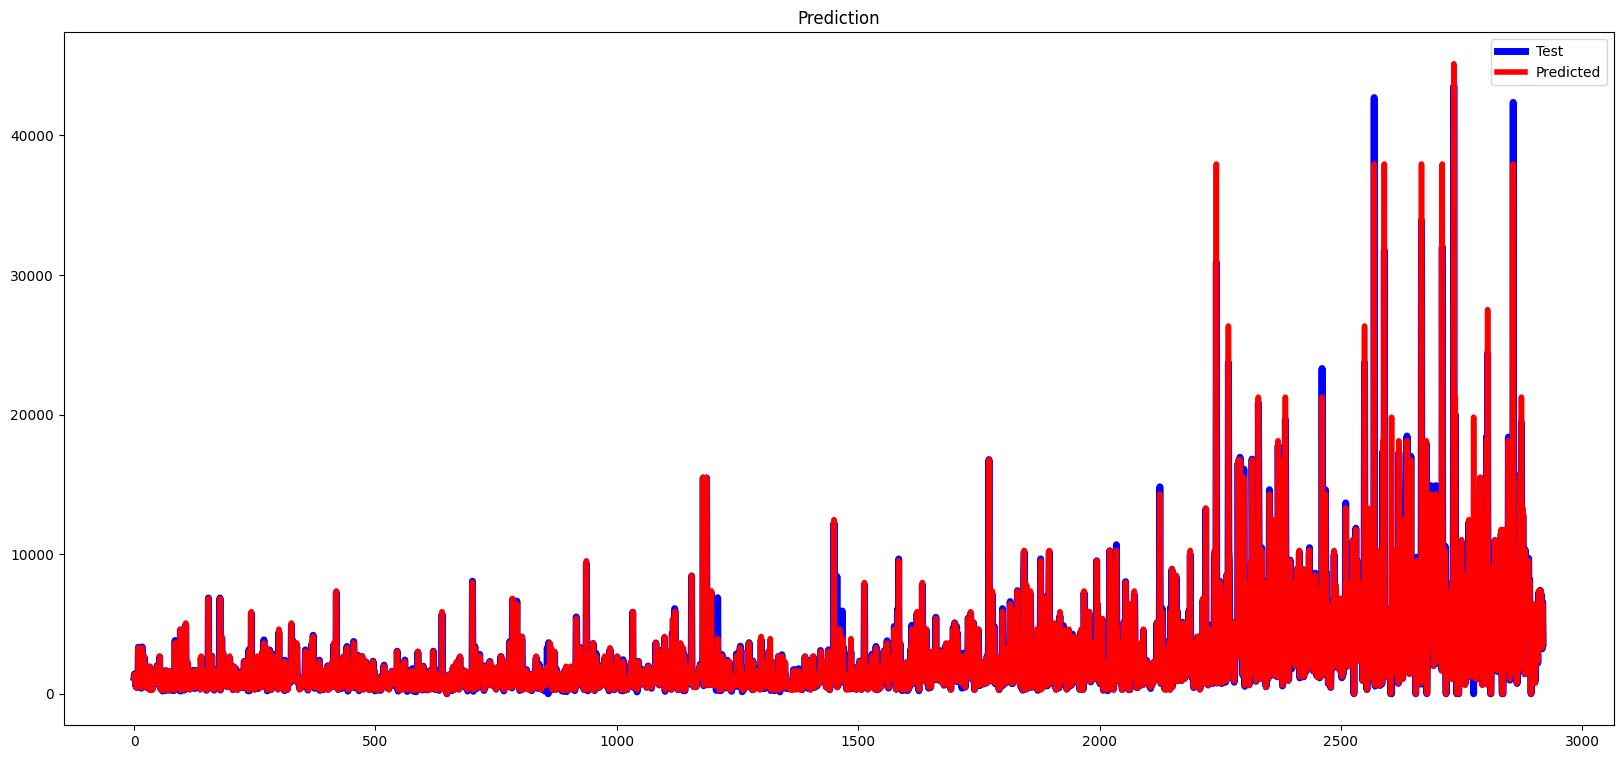

In [149]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(lGBMpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [150]:
y_true = y_test
score = r2_score(y_true, lGBMpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 96.0%


###  Финальный результат обучения модели на основе взвешенного арифметического среднего прогнозов

Помещаю все прогнозы модели в DataFrame

In [151]:
# second feature matrix
RFpreds=np.asanyarray(RFpreds)   
RFpreds=RFpreds.reshape(-1,1)  
TNpreds=np.asanyarray(TNpreds)   
TNpreds=TNpreds.reshape(-1,1) 
XGBpreds=np.asanyarray(XGBpreds)   
XGBpreds=XGBpreds.reshape(-1,1)
SVRpreds=np.asanyarray(lGBMpreds)   
SVRpreds=SVRpreds.reshape(-1,1) 

In [152]:
X_train2 = pd.DataFrame( {'RF': RFpreds.flatten(),
     'TN': TNpreds.flatten(),
     'XGB': XGBpreds.flatten(),
     'lGBM': lGBMpreds.flatten(),
    })
X_train2.head()

,RF,TN,XGB,lGBM
0,951.707706,1159.008789,1036.894043,1215.530155
1,1317.421379,1388.099243,1502.128174,1392.587484
2,942.814839,1107.679932,1036.894043,1046.610758
3,929.927178,933.334045,849.808594,898.254926
4,710.727893,625.181396,512.087585,449.939942


In [153]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_test)

# prediction using the test set
X_test2 = pd.DataFrame( {'RF': RFpreds.flatten(),
     'TN': TNpreds.flatten(),
     'XGB': XGBpreds.flatten(),
     'lGBM': lGBMpreds.flatten(),
    })

# Non-log scale
y_pred = reg.predict(X_test2)

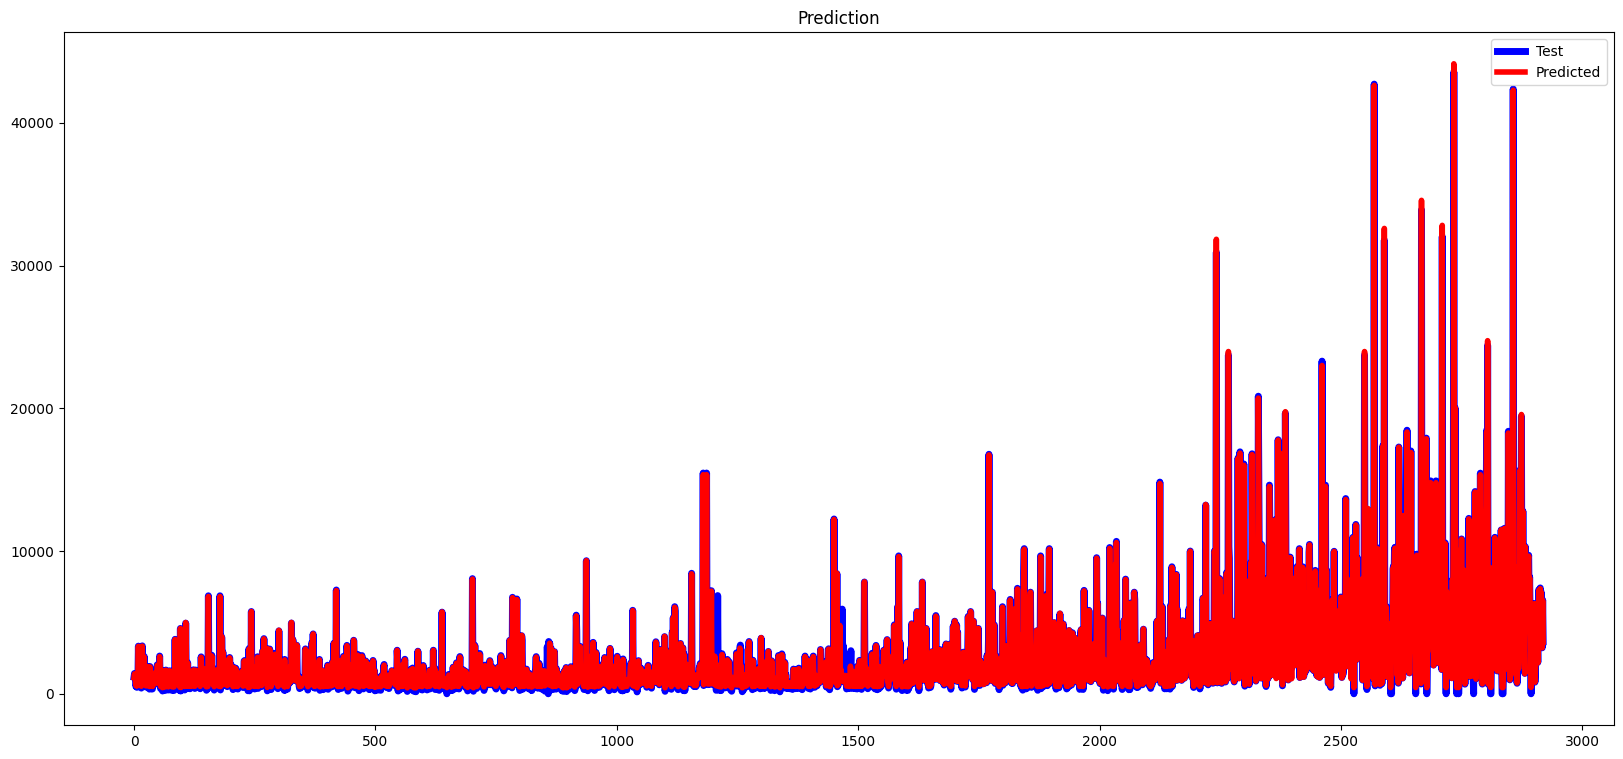

In [154]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(y_pred,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Prediction")
plt.show()

In [155]:
score = r2_score(y_true, y_pred)
print("Точность модели составляет {}%".format(round(score, 2) *100))

Точность модели составляет 99.0%


In [156]:
# Final Predictions on home prices
y_pred=np.asanyarray(y_pred)   
y_pred=y_pred.reshape(-1,1) 
submission = pd.DataFrame({
    # "Id": test_ID,
    "Data": y_pred.flatten()
})

## Show the first thirty predictions
submission[:30]

,Data
0,1140.416700
1,1399.222526
2,1079.133830
3,909.234730
4,574.113012
5,763.284487
6,544.880940
7,745.750319
8,883.497605
9,3321.032912


In [157]:
test = pd.DataFrame(y_test,columns=['Actual'])
pred = pd.DataFrame(y_pred,columns=['Predict'])

In [158]:
results = pd.concat([test,pred],axis=1)

In [159]:
results.head(50)

,Actual,Predict
0,1175.423729,1140.416700
1,1423.728814,1399.222526
2,1118.644068,1079.133830
3,917.796610,909.234730
4,500.000000,574.113012
5,742.372881,763.284487
6,453.372881,544.880940
7,711.864407,745.750319
8,881.355932,883.497605
9,3338.033898,3321.032912


In [160]:
dataForDates

,Unnamed: 0,InvoiceID,ProductID,TotalSales,Discount,CustomerID,Quantity
Date,,,,,,,
2019-12-27,0,328,1684,796.610169,143.389831,185,4
2019-12-27,1,329,524,355.932203,64.067797,185,2
2019-12-27,2,330,192,901.694915,162.305085,230,4
2019-12-27,3,330,218,182.754237,32.895763,230,1
2019-12-27,4,330,247,780.101695,140.418305,230,4
...,...,...,...,...,...,...,...
2023-01-13,29098,11092,1644,6573.000000,1183.140000,269,1
2023-01-13,29099,11093,352,5179.728814,932.351186,250,4
2023-01-13,29100,11094,683,7741.423729,1393.456271,415,4


In [161]:
timestep = 30
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[i] = Xin[i+1]
    Xin[timestep-1] = new_input
    #print ('After :\n', Xin)
    return Xin

In [162]:
# Этот раздел на неизвестное будущее
from datetime import timedelta
future=timestep
forcast = []
Xin = X_test2
Xin=np.asanyarray(Xin)   
print(Xin)
time=[]
for i in range(future):
    out = reg.predict(Xin)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(dataForDates.index[-1])+timedelta(days=i+1))

[[ 951.70770553 1159.00878906 1036.89404297 1215.53015549]
 [1317.42137933 1388.09924316 1502.12817383 1392.58748383]
 [ 942.81483892 1107.67993164 1036.89404297 1046.61075824]
 ...
 [3242.9083525  3093.96411133 3252.11450195 3295.57162489]
 [6594.95323619 6251.32519531 6704.37841797 6433.87571967]
 [3525.51155586 3515.9921875  3442.36987305 3645.54578373]]
[1140.4167004135272]
[1140.4167004135272, 1399.2225257442362]
[1140.4167004135272, 1399.2225257442362, 1079.1338297672846]
[1140.4167004135272, 1399.2225257442362, 1079.1338297672846, 909.2347295634469]
[1140.4167004135272, 1399.2225257442362, 1079.1338297672846, 909.2347295634469, 574.113012006969]
[1140.4167004135272, 1399.2225257442362, 1079.1338297672846, 909.2347295634469, 574.113012006969, 763.2844873656128]
[1140.4167004135272, 1399.2225257442362, 1079.1338297672846, 909.2347295634469, 574.113012006969, 763.2844873656128, 544.8809401126049]
[1140.4167004135272, 1399.2225257442362, 1079.1338297672846, 909.2347295634469, 574.11

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

In [163]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 

In [164]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [165]:
dataForDates.columns

Index(['Unnamed: 0', 'InvoiceID', 'ProductID', 'TotalSales', 'Discount',
       'CustomerID', 'Quantity'],
      dtype='object')

In [166]:
df_result

,Date,Forecasted
0,2023-01-15,1140.416700
1,2023-01-16,1399.222526
2,2023-01-17,1079.133830
3,2023-01-18,909.234730
4,2023-01-19,574.113012
5,2023-01-20,763.284487
6,2023-01-21,544.880940
7,2023-01-22,745.750319
8,2023-01-23,883.497605
9,2023-01-24,3321.032912


### График с результатом прогноза на будущие 180 дней

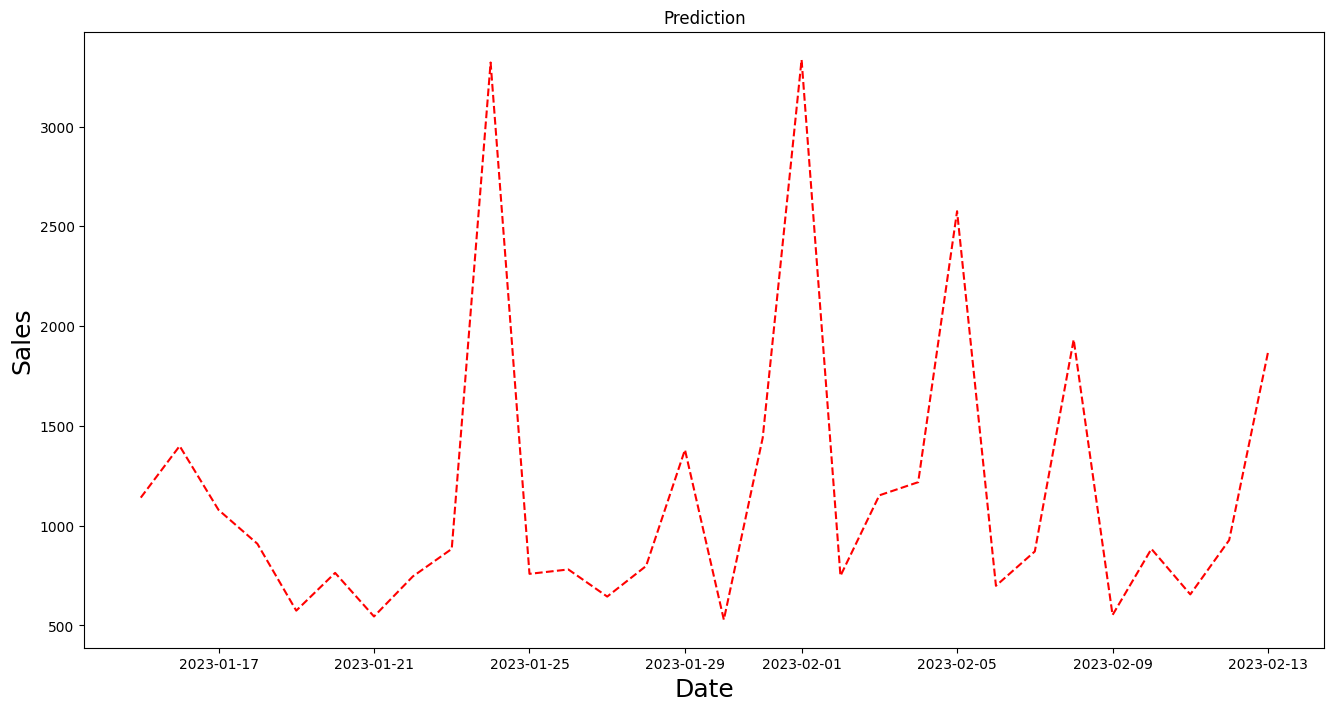

In [167]:
plt.figure(figsize=(16,8))
plt.title('Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales' ,fontsize=18)
plt.plot(df_result.set_index('Date')[['Forecasted']],"r--")